# Assignment 3  
In this Notebook, I'll predicting shares of article by using _multiple linear regression_. The data comes from [a study by Fernandes, Vinagre and Cortez](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

Linear regression is a model can be used to show or predict the relationship between two variables or factors. 
The essence of linear regression is to find a line that best fits the data points on the plot. We can use it to predict output values for inputs that are not present in the data set we have, with the belief that those outputs would fall on the line.

y = b0 +b1x+e

b0 is the y-intercept of the regression line.
b1 is the slope.
e is error term. 
A regression line can show a positive linear relationship, a negative linear relationship, or no relationship.

When two or more independent variables are used in regression analysis, the model is no longer a simple linear one. As this assignment will show,it is multiple regression.


In [3]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [4]:
#let's read the data first, to check the columns details
df = pd.read_csv('data Mashable.csv')  
df = df.dropna() #Let's get rid of rows with empty cells, because they will trip up a lot of the analyses
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24999 entries, 0 to 24998
Data columns (total 27 columns):
id                               24999 non-null int64
url                              24999 non-null object
n_tokens_title                   24999 non-null int64
n_tokens_content                 24999 non-null int64
num_imgs                         24999 non-null int64
num_videos                       24999 non-null int64
average_token_length             24999 non-null float64
data_channel_is_lifestyle        24999 non-null int64
data_channel_is_entertainment    24999 non-null int64
data_channel_is_bus              24999 non-null int64
data_channel_is_socmed           24999 non-null int64
data_channel_is_tech             24999 non-null int64
data_channel_is_world            24999 non-null int64
weekday_is_monday                24999 non-null int64
weekday_is_tuesday               24999 non-null int64
weekday_is_wednesday             24999 non-null int64
weekday_is_thursday     

,id,url,n_tokens_title,n_tokens_content,num_imgs,num_videos,average_token_length,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,...,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,global_subjectivity,global_sentiment_polarity,title_subjectivity,title_sentiment_polarity,shares,shares_log
0,1,http://mashable.com/2013/10/29/ashton-kutcher-...,10,821,12,0,4.518879,0,0,0,...,0,0,0,0,0.439379,0.082486,0.666667,0.375,2100,3.322219
1,2,http://mashable.com/2014/09/08/mashies-sept-19...,9,489,6,0,5.040900,0,0,0,...,0,0,0,0,0.300454,0.027715,0.000000,0.000,274,2.437751
2,3,http://mashable.com/2013/02/01/hello-kitty-roc...,11,131,0,1,4.877863,0,0,0,...,1,0,0,0,0.575486,0.259120,0.000000,0.000,1500,3.176091
3,4,http://mashable.com/2014/02/06/add-us-on-snapc...,8,556,2,0,4.974820,0,0,1,...,0,0,0,0,0.327220,0.134424,0.000000,0.000,2000,3.301030
4,5,http://mashable.com/2014/01/07/lindsey-vonn-wi...,9,880,18,0,4.928409,0,0,0,...,0,0,0,0,0.507709,0.109256,0.000000,0.000,6000,3.778151


The pre-processing steps:

Firstly,I want to have an overview of the data, so I start with a scatterplot matrix to check the relations of all variables with shares_log, also to see if there is any abnormal data

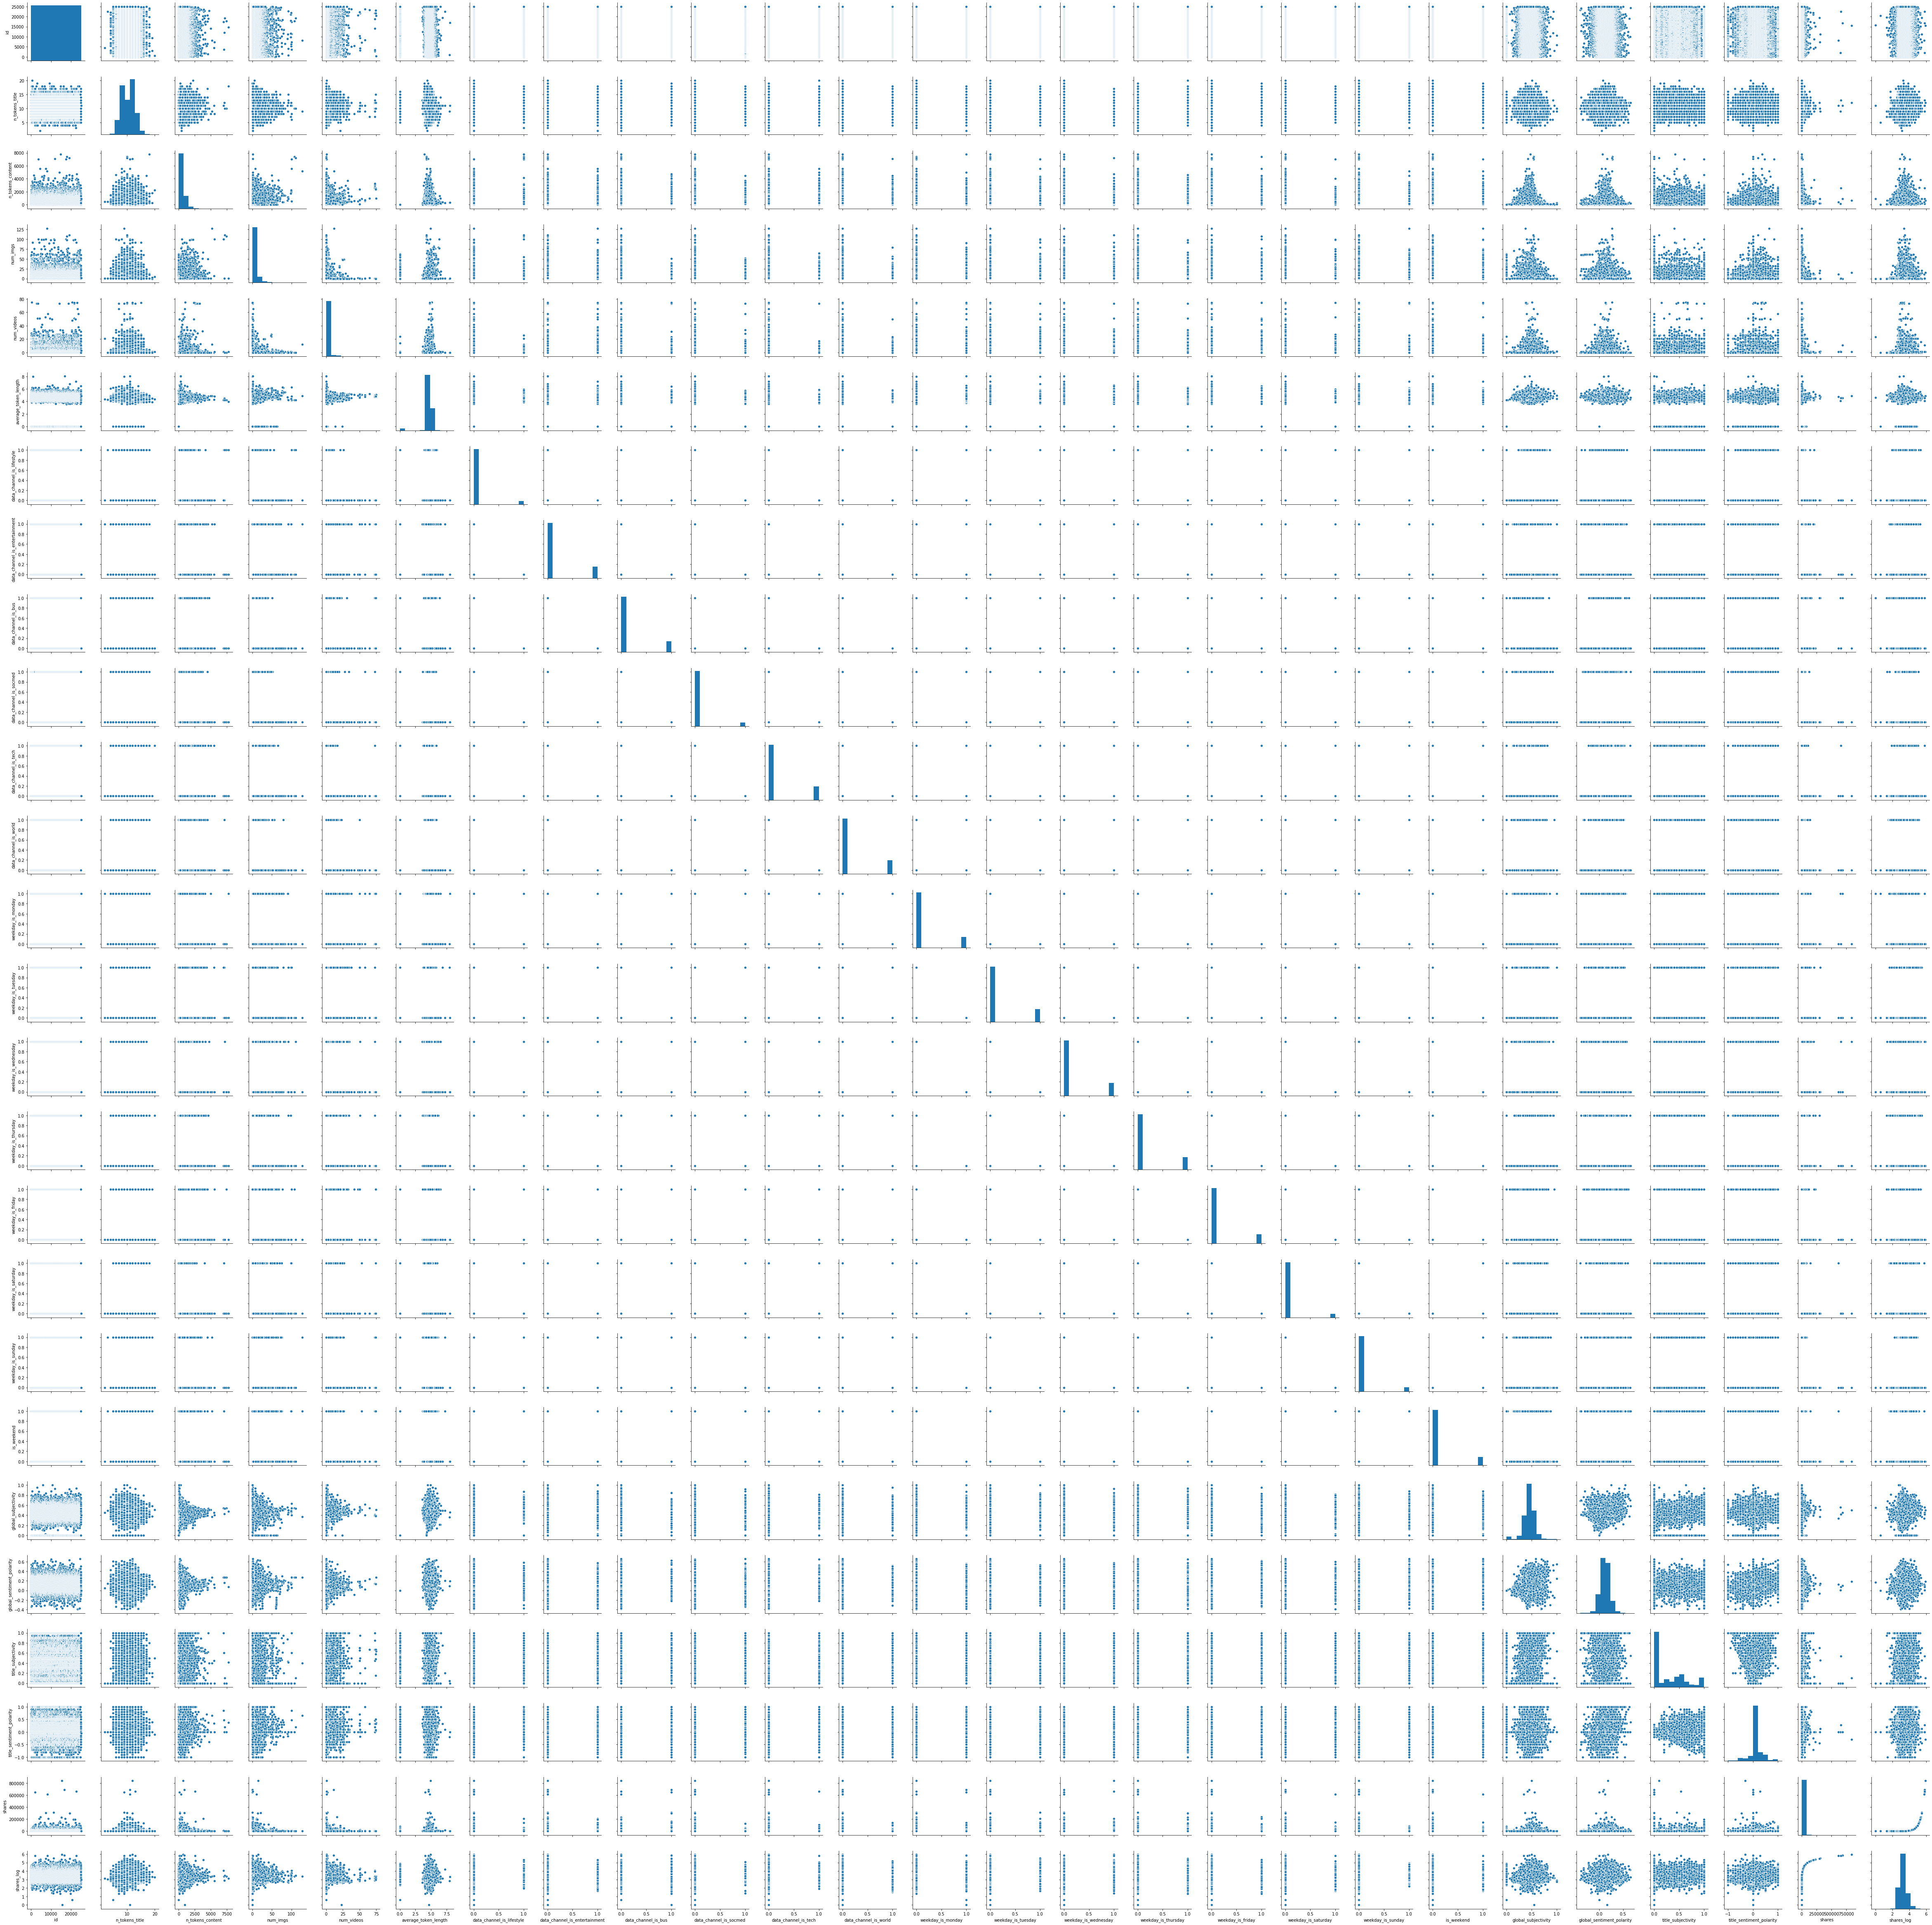

In [6]:
sns.pairplot(df)
plt.show()

From above scatterplot matrix.I found some abnormal data,for example many articles content number of words show 0,and some articles included images more than 100,and some articles included videos more than 50.These data really not match my impression of widely spread articles. 

Secondly, to dive into this,I decide to check above abnormal data by the id and url.

In [11]:
print(df[df.n_tokens_content == 0])
print(df[df.num_imgs > 100])
print(df[df.num_videos > 50])

          id                                                url  \
66        67    http://mashable.com/2014/09/17/tim-cooks-apple/   
153      154  http://mashable.com/2014/01/21/one-direction-s...   
172      173  http://mashable.com/2014/10/20/chilis-cook-fir...   
177      178  http://mashable.com/2014/04/03/60-events-marke...   
220      221  http://mashable.com/2014/02/13/comcast-time-wa...   
...      ...                                                ...   
24827  24828  http://mashable.com/2013/06/02/social-media-ga...   
24831  24832  http://mashable.com/2014/06/21/floral-photogra...   
24856  24857  http://mashable.com/2014/08/08/cbs-netflix-sho...   
24874  24875  http://mashable.com/2014/03/04/sad-clown-cover...   
24936  24937    http://mashable.com/2013/06/12/apple-ads-study/   

       n_tokens_title  n_tokens_content  num_imgs  num_videos  \
66                 11                 0         0           1   
153                14                 0         0           0   


I checked the id and url from above output, and found that the number of words of articles content are not really 0. And the number of images in articles also not really larger than 100, videos numbers also not really larger than 50.There is an shares value == 1, which is also very strange. 


Thirdly,I prefer too rughly clean these abnormal data.

In [5]:
df_new = df[(df['n_tokens_content'] != 0) & (df['num_imgs']<100) & (df['num_videos']<50) & (df['shares']>1)] 
df_new.head() 

,id,url,n_tokens_title,n_tokens_content,num_imgs,num_videos,average_token_length,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,...,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,global_subjectivity,global_sentiment_polarity,title_subjectivity,title_sentiment_polarity,shares,shares_log
0,1,http://mashable.com/2013/10/29/ashton-kutcher-...,10,821,12,0,4.518879,0,0,0,...,0,0,0,0,0.439379,0.082486,0.666667,0.375,2100,3.322219
1,2,http://mashable.com/2014/09/08/mashies-sept-19...,9,489,6,0,5.040900,0,0,0,...,0,0,0,0,0.300454,0.027715,0.000000,0.000,274,2.437751
2,3,http://mashable.com/2013/02/01/hello-kitty-roc...,11,131,0,1,4.877863,0,0,0,...,1,0,0,0,0.575486,0.259120,0.000000,0.000,1500,3.176091
3,4,http://mashable.com/2014/02/06/add-us-on-snapc...,8,556,2,0,4.974820,0,0,1,...,0,0,0,0,0.327220,0.134424,0.000000,0.000,2000,3.301030
4,5,http://mashable.com/2014/01/07/lindsey-vonn-wi...,9,880,18,0,4.928409,0,0,0,...,0,0,0,0,0.507709,0.109256,0.000000,0.000,6000,3.778151


I want to training a linear regression model to predict the number of shares, using exactly 5 variables (collections of dummy variables, such as weekday_is_monday, weekday_is_tuesday, etc. count as 1 variable).

From above scatterplot matrix, I choose following 5 variables : *n_tokens_content*,*num_images*,*weekday*,*global_subjectivity*,*title_subjectivity* 

In [6]:
df_sel = df_new[['n_tokens_content','num_imgs','weekday_is_monday','weekday_is_tuesday','weekday_is_wednesday','weekday_is_thursday','weekday_is_friday','weekday_is_saturday','weekday_is_sunday','global_subjectivity','title_subjectivity','shares_log']] 
df_sel.head()

,n_tokens_content,num_imgs,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,global_subjectivity,title_subjectivity,shares_log
0,821,12,0,1,0,0,0,0,0,0.439379,0.666667,3.322219
1,489,6,1,0,0,0,0,0,0,0.300454,0.000000,2.437751
2,131,0,0,0,0,0,1,0,0,0.575486,0.000000,3.176091
3,556,2,0,0,0,1,0,0,0,0.327220,0.000000,3.301030
4,880,18,0,1,0,0,0,0,0,0.507709,0.000000,3.778151


Above are 5 variables, including dummy variables that indicate weekdays with 0's and 1's. To set ourselves the target of predicting the shares.I'd like to make a new scatterplot matrix.

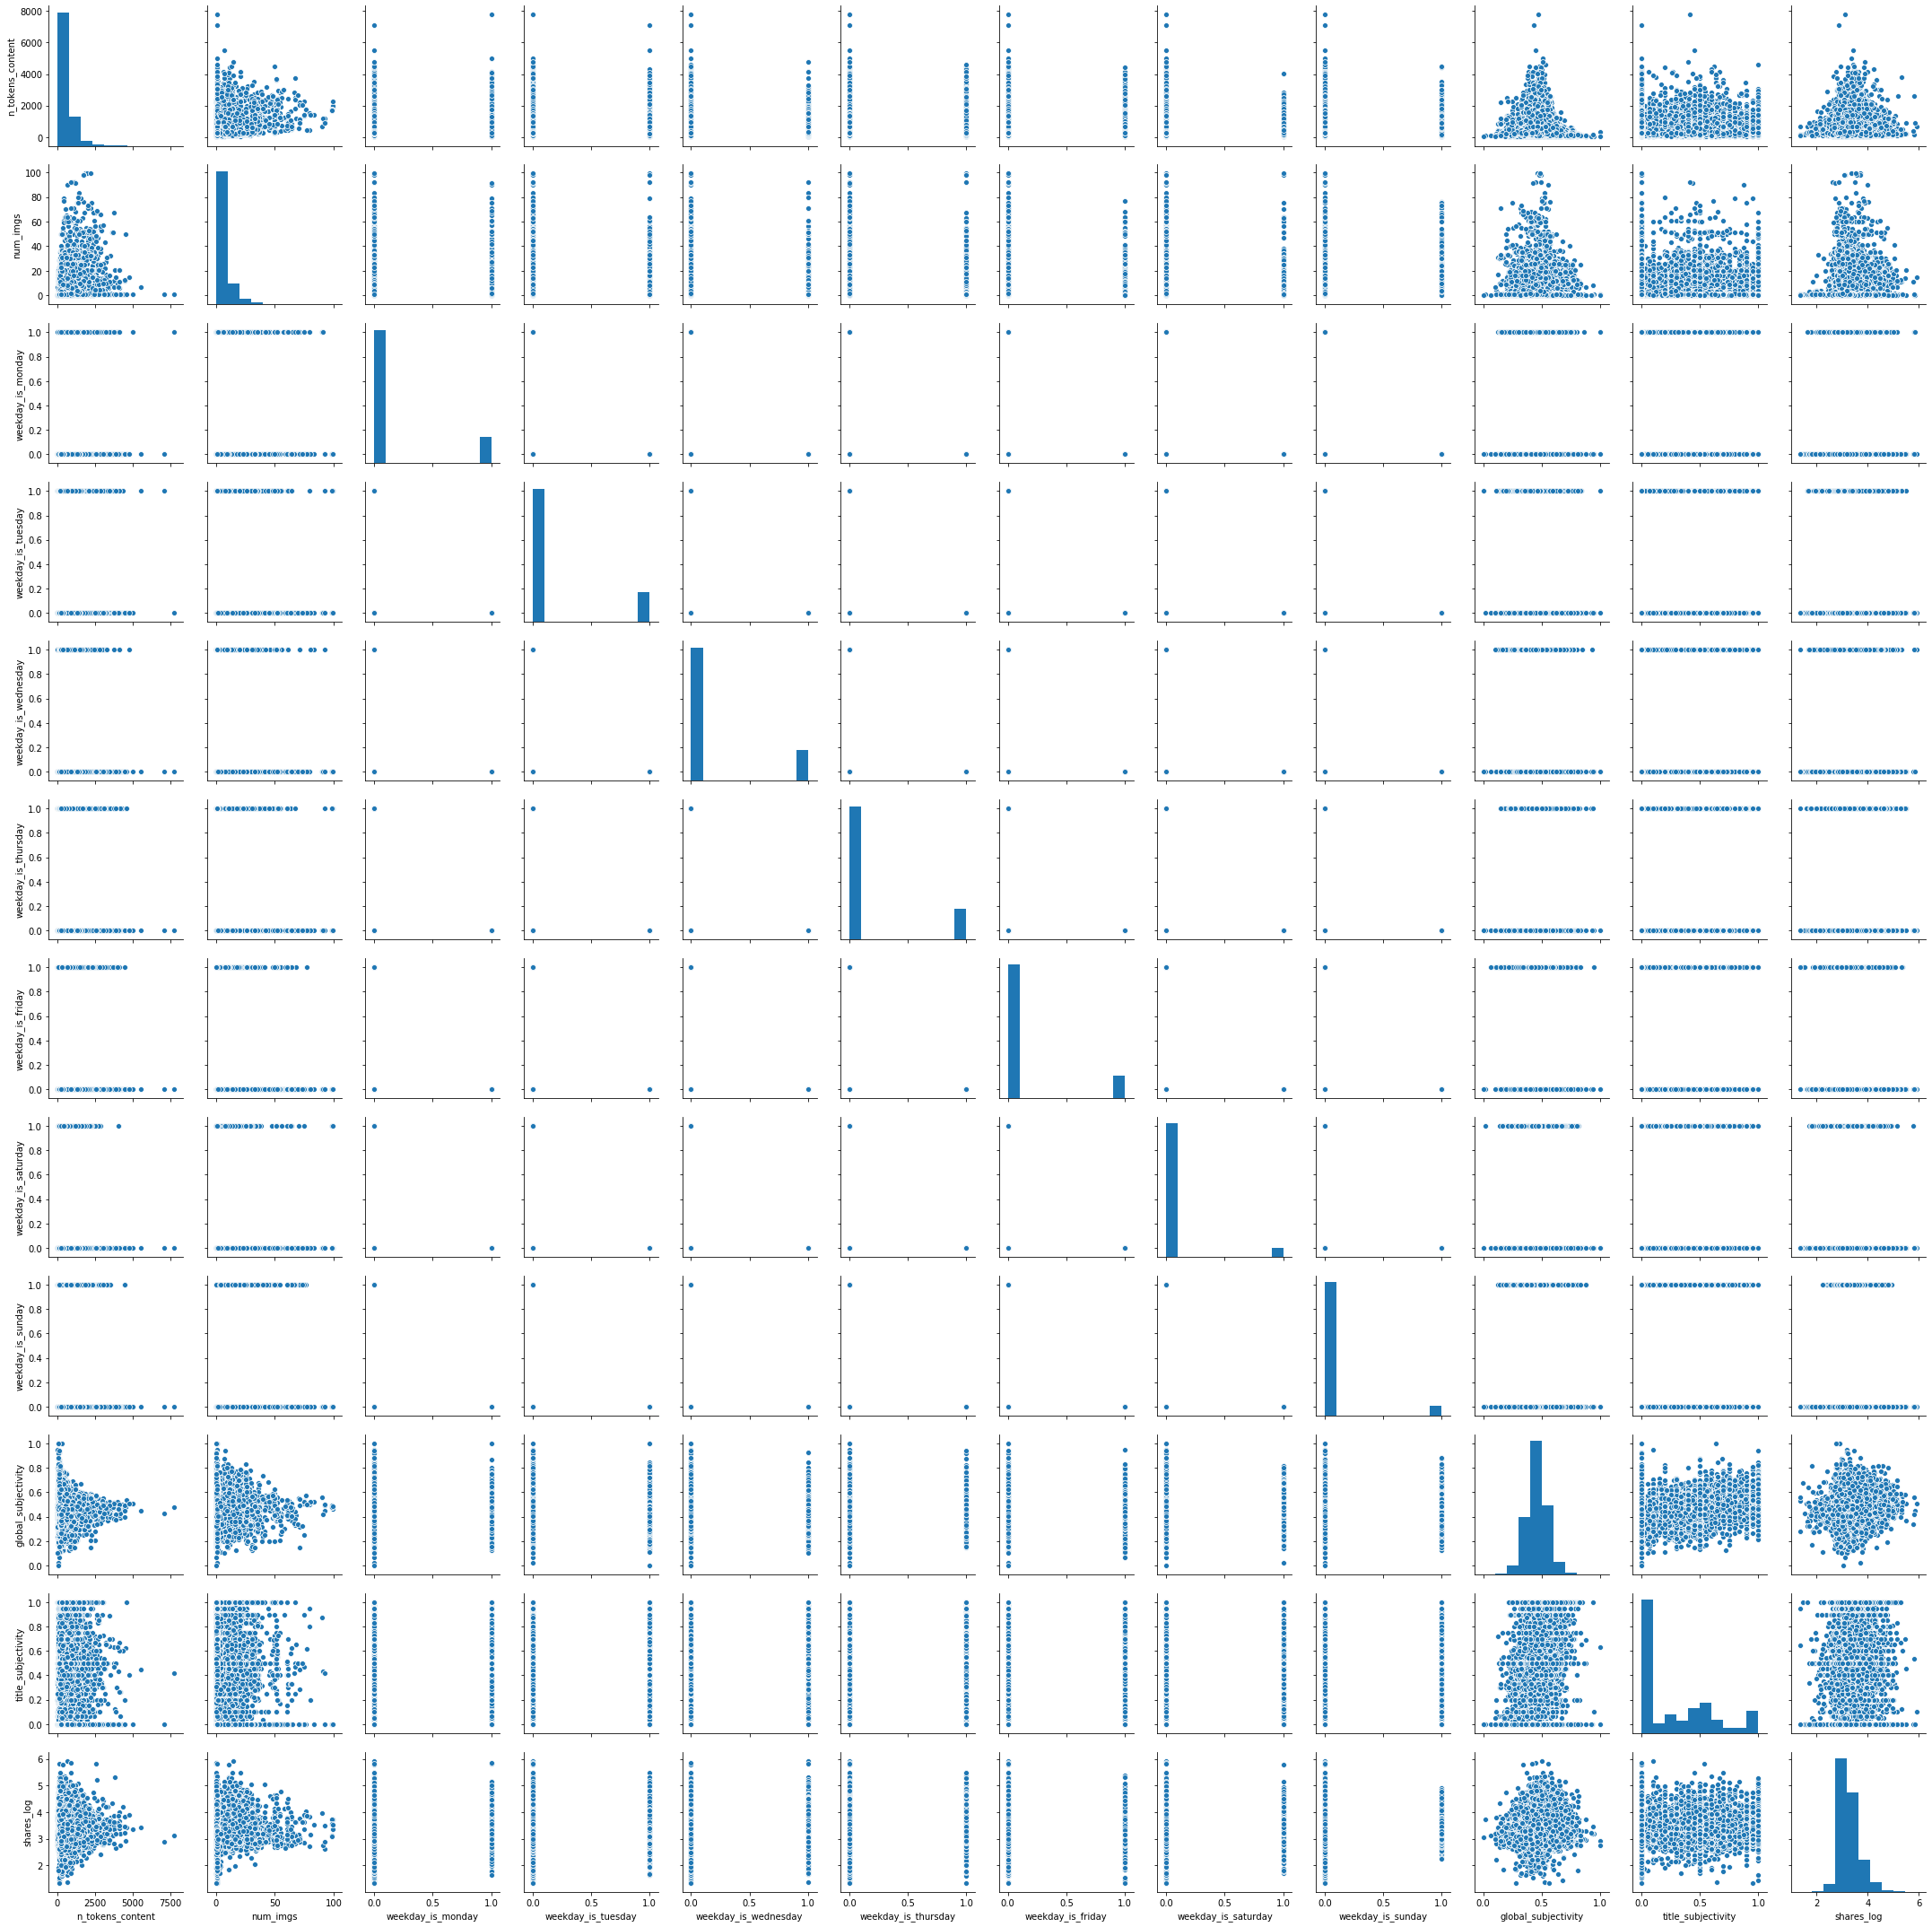

In [18]:
sns.pairplot(df_sel)
plt.show()

Look at the final row, with 'shares_log' on the Y-axis. 
Some of the variables seems have a correlation with shares_log, such as "num_imgs" and "global_subjectivity".

The qualitative variables show a less clear picture. We can make a correlation matrix to make things more clear. 
Correlations can also be calculated for 0/1 categorical variables.


In [7]:
df_sel.corr()

,n_tokens_content,num_imgs,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,global_subjectivity,title_subjectivity,shares_log
n_tokens_content,1.000000,0.347940,-0.003742,0.006460,-0.019230,-0.009465,-0.016856,0.034562,0.030251,-0.013215,0.006610,0.037313
num_imgs,0.347940,1.000000,0.000527,-0.000477,-0.027144,-0.005965,-0.011950,0.027226,0.041518,0.093298,0.058925,0.086373
weekday_is_monday,-0.003742,0.000527,1.000000,-0.213678,-0.214922,-0.213997,-0.183564,-0.114400,-0.122458,-0.014113,-0.011610,-0.006966
weekday_is_tuesday,0.006460,-0.000477,-0.213678,1.000000,-0.228879,-0.227893,-0.195484,-0.121828,-0.130410,-0.007060,0.001692,-0.028059
weekday_is_wednesday,-0.019230,-0.027144,-0.214922,-0.228879,1.000000,-0.229220,-0.196622,-0.122538,-0.131169,-0.010079,-0.013126,-0.032304
weekday_is_thursday,-0.009465,-0.005965,-0.213997,-0.227893,-0.229220,1.000000,-0.195775,-0.122010,-0.130604,-0.005435,-0.001280,-0.032386
weekday_is_friday,-0.016856,-0.011950,-0.183564,-0.195484,-0.196622,-0.195775,1.000000,-0.104659,-0.112031,0.010492,0.006619,0.006124
weekday_is_saturday,0.034562,0.027226,-0.114400,-0.121828,-0.122538,-0.122010,-0.104659,1.000000,-0.069819,0.023019,-0.000471,0.075216
weekday_is_sunday,0.030251,0.041518,-0.122458,-0.130410,-0.131169,-0.130604,-0.112031,-0.069819,1.000000,0.019080,0.027841,0.072792
global_subjectivity,-0.013215,0.093298,-0.014113,-0.007060,-0.010079,-0.005435,0.010492,0.023019,0.019080,1.000000,0.181533,0.134412


There are some correlations with shares_log and below variables: 

global_subjectivity, num_imgs, weekday_is_saturday, and weekday_is_sunday(in descending order)

I'll put them all in a linear model. 
For sk-learn to work, I first need to create separate X and Y that include the variables I want to use.


In [8]:
y = df_sel['shares_log'] #use shares_log as Y-variable
X = df_sel.loc[:,'n_tokens_content':'title_subjectivity'] #this slices the dataframe to include all rows and the columns from "n_tokens_content" to "title_subjectivity"
X.head()

,n_tokens_content,num_imgs,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,global_subjectivity,title_subjectivity
0,821,12,0,1,0,0,0,0,0,0.439379,0.666667
1,489,6,1,0,0,0,0,0,0,0.300454,0.000000
2,131,0,0,0,0,0,1,0,0,0.575486,0.000000
3,556,2,0,0,0,1,0,0,0,0.327220,0.000000
4,880,18,0,1,0,0,0,0,0,0.507709,0.000000


Use built-in function from sk-learn to split the data set randomly into a train set and a test set.

By stating random_state = 1, we use one particular "random state" (we could use any number, it's a so-called "random seed"). 
This means if we run the code again, it will produce the same results. Which can be handy.
test_size = 0.3, means to data into 70% training data and 30% test data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)#split data,then store datas into different variables
X_train.head() #The train data

,n_tokens_content,num_imgs,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,global_subjectivity,title_subjectivity
5484,177,0,0,0,0,1,0,0,0,0.507778,0.500000
3814,699,41,0,0,1,0,0,0,0,0.398410,0.000000
4884,463,1,1,0,0,0,0,0,0,0.580869,0.000000
9473,410,4,0,0,1,0,0,0,0,0.574348,0.700000
22966,699,1,0,0,0,1,0,0,0,0.481542,0.454545


Train the linear model.
Then check the coefficients.

In [10]:
lm = LinearRegression() #create the model
model = lm.fit(X_train, y_train) #train the model

In [11]:
coef = pd.DataFrame(X.columns.values, lm.coef_) #this creates a df with a column with the column names, and the coefficients of the model
coef

,0
0.000004,n_tokens_content
0.003450,num_imgs
-0.021121,weekday_is_monday
-0.049061,weekday_is_tuesday
-0.045660,weekday_is_wednesday
-0.046074,weekday_is_thursday
-0.014179,weekday_is_friday
0.100186,weekday_is_saturday
0.075909,weekday_is_sunday
0.562110,global_subjectivity


In [12]:
lm.intercept_

2.990041912010462

Interpret these coefficients as follows:

The intercept:2.990041912010462.

If an article published on Saturday, it adds 0.10 to its shares_log. 
If an article published on Sunday, it adds 0.0759 to its shares_log. 
If an article has more images(in range 0-100), it adds 0.003450 to its shares_log. 

For global_subjectivity (0-1), the rating increases with 0.562110	
For title_subjectivity (0-1), the rating increases with 0.028278		

In Markdown:

$𝑦=2.99+0.000004*x1+0.003450*x2+(-0.021121)*x3+0.049061*x4+(-0.045660)*x5+(-0.046074)*x6+(-0.014179)*x7+0.100186*x8+0.075909*x9+0.562110*x10+0.028278*x11$ 


where x1,x2,x3..x9,x10,x11 is n_tokens_content,num_imgs,weekday_is_monday,weekday_is_tuesday..weekday_is_saturday,weekday_is_sunday,global_subjectivity, title_subjectivity and y is shares_log



In [13]:
y_test_p = lm.predict(X_test) #Generate predictions for the test data. So we use X.test, not X.train
r2_score(y_test, y_test_p)


0.03233648513063525

In [14]:
math.sqrt(mean_squared_error(y_test, y_test_p)) 

0.4042935370904105

The R^2 is 0.03, which means only 3% of the variation in shares_log is explained by the model. That's means the model not really work.


RMSE: the root mean squared error.

The RMSE is 0.40. Which means that we are typically about 0.40 off in our predicted rating (which goes from 0-10). 

Finally, let's plot the predicted value against the actual rating.

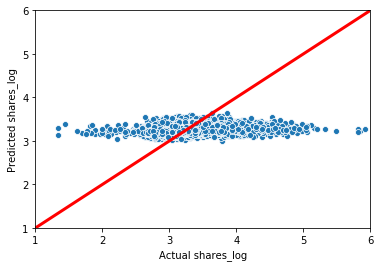

In [15]:
sns.scatterplot(y_test, y_test_p)
plt.xlabel('Actual shares_log')
plt.ylabel('Predicted shares_log')
plt.xlim([1,6]) #Forcing the x- and y-axis to be the same length, so that we can compare 
plt.ylim([1,6])
plt.plot([1, 6], [1, 6], color='red', lw=3) #Plot a diagonal length
plt.show()

Investigating the residuals

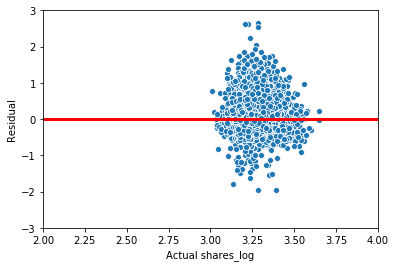

In [18]:
sns.scatterplot(y_test_p, y_test-y_test_p)
plt.xlabel('Actual shares_log')
plt.ylabel('Residual')
plt.xlim([2,4]) 
plt.ylim([-3,3])
plt.plot([2,4], [0,0], color='red', lw=3) #Plot a diagonal length
plt.show()

Compares to the shares_log , the residuals are too large.

The equation  $𝑦=2.99+0.000004*x1+0.003450*x2+(-0.021121)*x3+0.049061*x4+(-0.045660)*x5+(-0.046074)*x6+(-0.014179)*x7+0.100186*x8+0.075909*x9+0.562110*x10+0.028278*x11$  

can't explain relations between the variables and shares_log.